In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Devise

[DeViSE: A Deep Visual-Semantic Embedding Model](http://papers.nips.cc/paper/5204-devise-a-deep-visual-semantic-embedding-model.pdf)

Lets bring together text and images [1:55:49], per paper above from Google. 
Both words and images can have a distributed representation space, ie as vectors.
Lets merge the two representations, and encourage the vector space 
so that images end up with be the same vector space that the words are in.
Assume we have 2 models, A, and B, and an image X of a Corgi dog.
A predicts that X is a beagle and B predicts it is a plane.  
The image loss function says that both A and B are equally "good" (i.e. both wrong). 
But in word space, a Corgi is closer to a Beagle than to a plane.  
So model A is better than model B, as its prediction is "closer". 

It would also allow us to search for things that are not in ImageNet Synset ID (i.e. a category in ImageNet). 
Why train a new model to find dog vs. cats, when we have one that found corgis and tabbies? 
Lets just say "find me dogs". 

Earlier we train a model that was learning a category (one hot encoded ID), 
where every category is equally far from every other category.
Now lets train a model where the dependent variable is a word vector for what we are looking for. 
So if it’s Corgi (airplane), lets train it to create a word vector that corresponds to the Corgi (airplane) word vector.

In [2]:
import fastai
from fastai.conv_learner import *
torch.backends.cudnn.benchmark=True

import fastText as ft

import torchvision.transforms as transforms

In [3]:
PATH = Path('data/imagenet/ILSVRC/Data/CLS-LOC/')
TMP_PATH = PATH/'tmp'
TRANS_PATH = Path('data/translate/')
PATH_TRN = PATH/'train'

In [4]:
arch=resnet50
ttfms,vtfms = tfms_from_model(arch, 224, transforms_side_on, max_zoom=1.1)
def to_array(x,y): return np.array(x).astype(np.float32)/255,None
def TT(x,y): return torch.from_numpy(x),None

ttfms.tfms = [to_array] + ttfms.tfms# + [TT]

In [5]:
#ttfms(img)

Let’s grab the fast text word vectors again, load them in (we only need English this time).

In [6]:
ft_vecs = ft.load_model(str((TRANS_PATH/'wiki.en.bin')))

In [7]:
ft_vecs.get_word_vector('king')   # The vector for king.

array([ 0.03259, -0.18164, -0.29049, -0.10506, -0.16712, -0.07748, -0.5661 , -0.08622, -0.00216,  0.15366,
        0.12189, -0.14722,  0.01511,  0.07209, -0.02156, -0.20612, -0.02104, -0.01999, -0.15506,  0.00802,
       -0.22746,  0.33518, -0.10629, -0.50318, -0.1582 ,  0.27829,  0.05752, -0.32697,  0.04766,  0.01076,
        0.13972, -0.12445, -0.18989,  0.32969, -0.32513,  0.10958,  0.21962, -0.47215,  0.03422, -0.2207 ,
        0.02177,  0.0832 , -0.04776, -0.48873,  0.05207, -0.15001, -0.19203,  0.06177,  0.15535, -0.05598,
        0.11071,  0.39161, -0.17716,  0.05449,  0.25898, -0.13954,  0.4272 , -0.07273, -0.4714 ,  0.04993,
        0.29526, -0.05319,  0.03451, -0.10583, -0.30137,  0.16372,  0.07541,  0.21018, -0.11459,  0.10976,
        0.04923,  0.17688,  0.45658, -0.59762, -0.0039 ,  0.08866,  0.53103,  0.153  , -0.1673 ,  0.13121,
       -0.05547, -0.03582, -0.34535,  0.09128,  0.03323,  0.45211, -0.16894,  0.21139,  0.24153,  0.51014,
       -0.01474, -0.47179,  0.2235 , 

In [8]:
np.corrcoef(ft_vecs.get_word_vector('jeremy'), ft_vecs.get_word_vector('Jeremy')) # correlation 0.6

array([[1.     , 0.60866],
       [0.60866, 1.     ]])

In [9]:
np.corrcoef(ft_vecs.get_word_vector('banana'), ft_vecs.get_word_vector('Jeremy')) # Correlation 0.14

array([[1.     , 0.14482],
       [0.14482, 1.     ]])

Words that you would expect to be correlated are correlated and words that should far away from each other as possible, unfortunately, they are still slightly correlated but not so much [1:59:41].

### Map imagenet classes to word vectors
Let's grab all of the ImageNet classes, to know which one is corgi and which one is airplane.

In [10]:
ft_words = ft_vecs.get_words(include_freq=True)
ft_word_dict = {k:v for k,v in zip(*ft_words)}
ft_words = sorted(ft_word_dict.keys(), key=lambda x: ft_word_dict[x])

len(ft_words)

2519370

In [11]:
from fastai.io import get_data

We have a list of all of those classes on files.fast.ai that we can grab them.

In [12]:
CLASSES_FN = 'imagenet_class_index.json'
get_data(f'http://files.fast.ai/models/{CLASSES_FN}', TMP_PATH/CLASSES_FN)

Let’s grab a list of all of the English nouns, per [WordNet](https://wordnet.princeton.edu/) 
a large English lexical database. 
Nouns, verbs, adjectives and adverbs are grouped into sets of cognitive synonyms (synsets), 
each expressing a distinct concept.

In [13]:
WORDS_FN = 'classids.txt'
get_data(f'http://files.fast.ai/data/{WORDS_FN}', PATH/WORDS_FN)

Now load that list of ImageNet classes, turn that into a dictionary, so `classids_1k` contains the class IDs for the 1000 images that are in the competition dataset.

In [14]:
class_dict = json.load((TMP_PATH/CLASSES_FN).open())
classids_1k = dict(class_dict.values())
nclass = len(class_dict); nclass

1000

In [15]:
class_dict['0']   # tench is a fish...

['n01440764', 'tench']

Let’s do the same thing for all those WordNet nouns [2:01:11]. 
ImageNet also uses WordNet class names so it is easy to map between the two.

In [16]:
classid_lines = (PATH/WORDS_FN).open().readlines()
classid_lines[:5]

['n00001740 entity\n',
 'n00001930 physical_entity\n',
 'n00002137 abstraction\n',
 'n00002452 thing\n',
 'n00002684 object\n']

In [17]:
classids = dict(l.strip().split() for l in classid_lines)
len(classids),len(classids_1k)

(82115, 1000)

In [18]:
lc_vec_d = {w.lower(): ft_vecs.get_word_vector(w) for w in ft_words[-1000000:]}

Map the two words together, create a couple of dictionaries 
to map them based on the Synset ID or the WordNet ID.

Now let's grab the 82,000 nouns in WordNet and look them up in fast text. 

In [19]:
syn_wv = [(k, lc_vec_d[v.lower()]) for k,v in classids.items()
          if v.lower() in lc_vec_d]
syn_wv_1k = [(k, lc_vec_d[v.lower()]) for k,v in classids_1k.items()
          if v.lower() in lc_vec_d]
syn2wv = dict(syn_wv)
len(syn2wv)

49469

We found 49,469 of them in fast text. 
We now have a dictionary that goes from *synset ID* (what WordNet calls them) to word vectors. 
We also have the same thing specifically for the 1K ImageNet classes.

In [20]:
pickle.dump(syn2wv, (TMP_PATH/'syn2wv.pkl').open('wb'))
pickle.dump(syn_wv_1k, (TMP_PATH/'syn_wv_1k.pkl').open('wb'))

In [21]:
syn2wv = pickle.load((TMP_PATH/'syn2wv.pkl').open('rb'))
syn_wv_1k = pickle.load((TMP_PATH/'syn_wv_1k.pkl').open('rb'))

## DATA, ARCHITECTURE and LOSS FUNCTION
### Data

NB: Use this [script](https://raw.githubusercontent.com/soumith/imagenetloader.torch/master/valprep.sh) to populate the valid directory for Imagenet.

In [22]:
images = []
img_vecs = []

j = 0
for d in (PATH/'train').iterdir():
    if d.name not in syn2wv: continue
    vec = syn2wv[d.name]
    for f in d.iterdir():
        images.append(str(f.relative_to(PATH)))
        img_vecs.append(vec)
        j += 1

n_val=0
for d in (PATH/'valid').iterdir():
    if d.name not in syn2wv: continue
    vec = syn2wv[d.name]
    for f in d.iterdir():
        images.append(str(f.relative_to(PATH)))
        img_vecs.append(vec)
        n_val += 1

In [23]:
n_val, j

(28700, 739526)

It has a validation set of approx. 28K items in it. 
For every image in ImageNet, we can grab its fast text word vector using the synset to word vector (syn2wv).
We can stick that into the image vectors array (img_vecs), stack that all up into a single matrix and save. 

In [24]:
img_vecs = np.stack(img_vecs)
img_vecs.shape

(768226, 300)

Now for every ImageNet image we have the fast text word vector that it is associated with.
[2:03:43] by looking up the synset ID → WordNet → Fast text → word vector.

In [25]:
pickle.dump(images, (TMP_PATH/'images.pkl').open('wb'))
pickle.dump(img_vecs, (TMP_PATH/'img_vecs.pkl').open('wb'))

In [26]:
images = pickle.load((TMP_PATH/'images.pkl').open('rb'))
img_vecs = pickle.load((TMP_PATH/'img_vecs.pkl').open('rb'))

In [27]:
arch = resnet50

In [28]:
n = len(images); n

768226

In [29]:
val_idxs = list(range(n-28650, n))

[2:04:06]. 
We can now create an image classifier data object (`md`).
`from_names_and_array` we give a list of file names (eg all file names in ImageNet) 
and an array of our dependent variables (all of the fast text word vectors). 
We can then pass in the validation indexes. 
(Here just all of the last IDs — make sure they are the same as ImageNet uses). 
Then we pass in `continuous=True` (image regressive data so), i.e., 
don’t one hot encode my outputs but treat them just as continuous values. 



In [30]:
tfms = tfms_from_model(arch, 224, transforms_side_on, max_zoom=1.1)
md = ImageClassifierData.from_names_and_array(PATH, images, img_vecs, val_idxs=val_idxs,
        classes=None, tfms=tfms, continuous=True, bs=64) #256)

In [31]:
x,y = next(iter(md.val_dl))

Now the model data object (`md`) has all of the file names,
and for every file name a continuous array representing the word vector for that. 
So we have data, now we need an architecture and the loss function.

### Architecture
Let’s create a simple architecture [2:05:26]. 
Fastai has a `ConvnetBuilder` which gets called by `ConvLerner.pretrained` with parameters:
- `f`: the architecture (eg ResNet50)
- `c`: how many classes (here it’s not classes, it’s how many outputs, which is the length of the fast text word vector i.e. 300).
- `is_multi`: It is **not** a multi classification. (not classification at all).
- `is_reg`: Yes, it is a regression.
- `ps` : dropout. JH found the default dropout was under-fitting, so it decreased from 0.5 to 0.2.
- `xtra_fc` : What Fully Connected layers you want. 

We add a fully connected hidden layer with length 1024. 
(The last layer of ResNet50 is 1024 long, the final output we need is 300 long).
The penultimate (second to the last) layer must be longer than 300, else it’s not enough information.
So JH picked something bigger and it worked ok. 

This is a ConvNet that does not have any softmax (because it’s regression),
it’s just a linear layer at the end. [2:06:55]. 
We can create a ConvLearner from that model and give it an optimization function. 

In [32]:
models = ConvnetBuilder(arch, md.c, is_multi=False, is_reg=True, xtra_fc=[1024], ps=[0.2,0.2])

learn = ConvLearner(md, models, precompute=True)
learn.opt_fn = partial(optim.Adam, betas=(0.9,0.99))

/home/german/DeepLearning/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


### Loss Function 
[2:07:38]: 
Default loss function for regression is L1 loss (the absolute differences). 
Unfortunately in really high dimensional spaces everything is on the outside (in this case, it’s 300 dimensional). 
When everything is on the outside, distance is not meaningless, but a little bit awkward. 
Things tend to be close together or far away, it doesn’t really mean much in these 
really high dimensional spaces where everything is on the edge. 

But the **angle** between those vectors **is meaningful**. 
We use **[cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity)** to find how close/apart vectors are in high dimensional spaces. 
Cosine similarity is normalized to be a unit norm (i.e., divided by the length). 
So we don’t care about the length of the vector, only its angle. 
[2:09:13]. 

With an alternative custom loss function, it may/would still work but less good. 

In [33]:
def cos_loss(inp,targ): return 1 - F.cosine_similarity(inp,targ).mean()
learn.crit = cos_loss

## Train

We have data, architecture, and loss function, lets go ahead and fit.

In [34]:
%time learn.lr_find(start_lr=1e-4, end_lr=1e15)

epoch      trn_loss   val_loss                                  
    0      1.0        1.0       

CPU times: user 6min 11s, sys: 3min 10s, total: 9min 21s
Wall time: 5min 52s


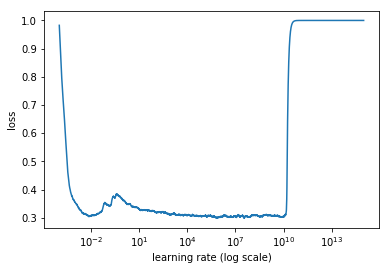

In [35]:
learn.sched.plot()

In [36]:
lr = 1e-2
wd = 1e-7

We are training on all of ImageNet, will take a long time. 
`precompute=True` caches the output of the final convolutional layer and just trains the fully connected bit. 
Still, it takes 3+ minutes to train an epoch on all of ImageNet. 
So this is about an hour worth of training, but it’s pretty cool that with fastai, 
we can train a new custom head on all of ImageNet for 40 epochs in an hour or so.

In [37]:
learn.precompute=True

In [38]:
%time learn.fit(lr, 1, cycle_len=20, wds=wd, use_clr=(20,10))

epoch      trn_loss   val_loss                                   
    0      0.221236   0.202363  
    1      0.206746   0.189378                                   
    2      0.214719   0.197852                                   
    3      0.22718    0.205263                                   
    4      0.213083   0.196077                                   
    5      0.214756   0.19076                                    
    6      0.210169   0.193508                                   
    7      0.210342   0.184247                                   
    8      0.2051     0.183428                                   
    9      0.207191   0.188132                                   
    10     0.208606   0.187462                                   
    11     0.202897   0.184126                                   
    12     0.196906   0.179945                                   
    13     0.196386   0.176198                                   
    14     0.19328    0.173421             

[0.16071684083389362]

In [39]:
learn.bn_freeze(True)

In [40]:
%time learn.fit(lr, 1, cycle_len=20, wds=wd, use_clr=(20,10))

epoch      trn_loss   val_loss                                   
    0      0.132345   0.136977  
    1      0.133424   0.137876                                   
    2      0.125525   0.135428                                   
    3      0.122806   0.13409                                    
    4      0.120064   0.132899                                   
    5      0.12261    0.13217                                    
    6      0.118964   0.132752                                   
    7      0.123114   0.130229                                   
    8      0.11841    0.129554                                   
    9      0.12125    0.129588                                   
    10     0.120754   0.129481                                   
    11     0.120289   0.129707                                   
    12     0.118313   0.128034                                   
    13     0.117047   0.127619                                   
    14     0.115432   0.12836              

[0.1227608361835047]

In [41]:
lrs = np.array([lr/1000,lr/100,lr])

In [42]:
learn.precompute=False
learn.freeze_to(1)

In [43]:
learn.save('pre0')

In [44]:
learn.load('pre0')

## Image search

### Search imagenet classes
Now lets grab the 1000 ImageNet classes, and lets predict on our whole validation set, and take a look at a few pictures [2:10:26].

In [45]:
syns, wvs = list(zip(*syn_wv_1k))
wvs = np.array(wvs)

In [46]:
%time pred_wv = learn.predict()

CPU times: user 9min 40s, sys: 3min 55s, total: 13min 36s
Wall time: 1min 15s


In [47]:
start=300

In [48]:
denorm = md.val_ds.denorm

def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.axis('off')
    return ax

def show_imgs(ims, cols, figsize=None):
    fig,axes = plt.subplots(len(ims)//cols, cols, figsize=figsize)
    for i,ax in enumerate(axes.flat): show_img(ims[i], ax=ax)
    plt.tight_layout()

Because validation set is ordered, all the stuff of the same type are in the same place.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


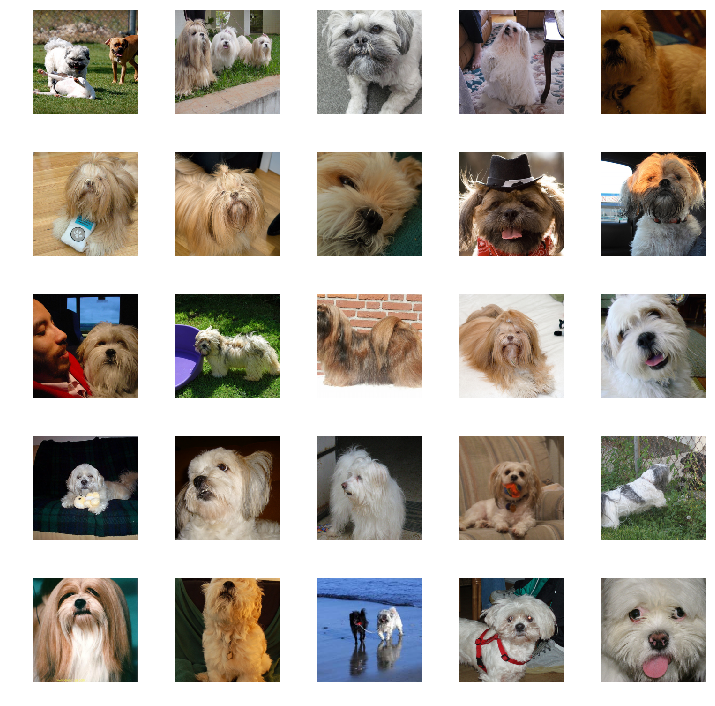

In [49]:
show_imgs(denorm(md.val_ds[start:start+25][0]), 5, (10,10))

### Nearest neighbor search 
[2:10:56]: 
Given a set of 300 dimensional vectors $S$, and a vector, $x \in S$  
which things is $x$ closest to? 
Normally that takes long time to look through every 300 dimensional vector in $S$, 
calculate its distance, and find out how far away it is. 

**[NMSLib](https://pypi.org/project/nmslib/)** is multi-threaded and fastest as benchmarked by experts.
```
!pip install nmslib
```
We create an index on angular distance for all the ImageNet word vectors. 
Adding a whole batch, create the index, and now query many vectors all at once, get the 10 nearest neighbors. 


In [50]:
import nmslib

def create_index(a):
    index = nmslib.init(space='angulardist')
    index.addDataPointBatch(a)
    index.createIndex()
    return index

def get_knns(index, vecs):
     return zip(*index.knnQueryBatch(vecs, k=10, num_threads=4))

def get_knn(index, vec): return index.knnQuery(vec, k=10)

In [51]:
nn_wvs = create_index(wvs)

It tells you how far away they are and their indexes [2:12:13].

In [52]:
idxs,dists = get_knns(nn_wvs, pred_wv)

So now we can go through and print out the top 3.

In [53]:
[[classids[syns[id]] for id in ids[:3]] for ids in idxs[start:start+10]]

[['affenpinscher', 'Doberman', 'otterhound'],
 ['Lhasa', 'stupa', 'monastery'],
 ['Lhasa', 'stupa', 'monastery'],
 ['Lhasa', 'stupa', 'monastery'],
 ['Lhasa', 'stupa', 'monastery'],
 ['Lhasa', 'stupa', 'monastery'],
 ['Lhasa', 'stupa', 'monastery'],
 ['Lhasa', 'stupa', 'monastery'],
 ['Lhasa', 'stupa', 'monastery'],
 ['Lhasa', 'stupa', 'monastery']]

This is not a particularly hard: there are only 1000 ImageNet classes, it is not anything new. 
Now, lets bring in **all of WordNet** and ask, which of those 49K? things is it closest to?

### Search all wordnet noun classes

In [54]:
all_syns, all_wvs = list(zip(*syn2wv.items()))
all_wvs = np.array(all_wvs)

In [55]:
nn_allwvs = create_index(all_wvs)

In [56]:
idxs,dists = get_knns(nn_allwvs, pred_wv)

In [57]:
[[classids[all_syns[id]] for id in ids[:3]] for ids in idxs[start:start+10]]

[['pinscher', 'affenpinscher', 'coonhound'],
 ['Lhasa', 'Lhasa', 'Tibet'],
 ['Lhasa', 'Lhasa', 'Tibet'],
 ['Lhasa', 'Lhasa', 'Tibet'],
 ['Lhasa', 'Lhasa', 'Tibet'],
 ['Lhasa', 'Lhasa', 'Tibet'],
 ['Lhasa', 'Lhasa', 'Tibet'],
 ['Lhasa', 'Lhasa', 'Tibet'],
 ['Lhasa', 'Lhasa', 'Tibet'],
 ['Lhasa', 'Lhasa', 'Tibet']]

Exactly the same result. It is now searching all of the WordNet.

### Text -> image search

[2:13:16]
Now take all the predictions (`pred_wv`) (so basically take our whole validation set of images) 
and create a KNN index of the image representations.
Note that it is predicting things that are meant to be word vectors. 

In [58]:
nn_predwv = create_index(pred_wv)

In [59]:
en_vecd = pickle.load(open(TRANS_PATH/'wiki.en.pkl','rb'))

For example, let’s grab the fast text vector for *“boat”*.
*boat* is **not an ImageNet concept**.
Yet we can now find (all?) of the images in our predicted word vectors 
(i.e. our validation set) that are closest to the word boat! 
This works even though it is not something that was ever trained on.

In [60]:
vec = en_vecd['boat']

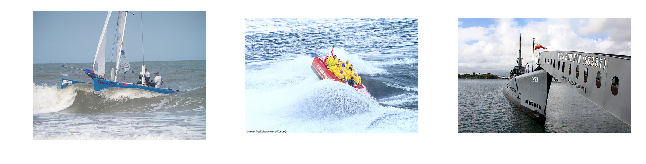

In [61]:
idxs,dists = get_knn(nn_predwv, vec)
show_imgs([open_image(PATH/md.val_ds.fnames[i]) for i in idxs[:3]], 3, figsize=(9,3));

Now lets take `engine`’s vector and `boat`’s vector and take their average.
Then look for the  nearest neighbors... 
[2:14:04]?

In [62]:
vec = (en_vecd['engine'] + en_vecd['boat'])/2

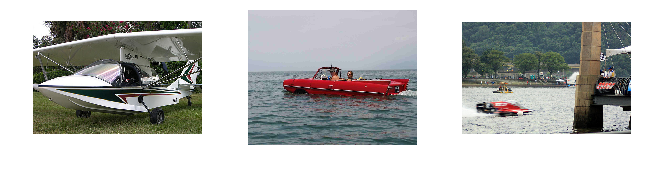

In [63]:
idxs,dists = get_knn(nn_predwv, vec)
show_imgs([open_image(PATH/md.val_ds.fnames[i]) for i in idxs[:3]], 3, figsize=(9,3));

These are boats with engines. 

*sail* is not an ImageNet class. 
Below is the average of 2 concepts that are not ImageNet classes...sail-boats.

In [64]:
vec = (en_vecd['sail'] + en_vecd['boat'])/2

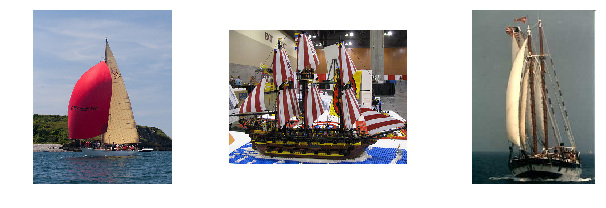

In [65]:
idxs,dists = get_knn(nn_predwv, vec)
show_imgs([open_image(PATH/md.val_ds.fnames[i]) for i in idxs[:3]], 3, figsize=(9,3));

### Image->image search

[2:14:35]
Let’s open up an image `img` in the validation set. 

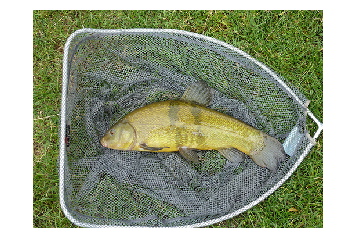

In [66]:
fname = 'valid/n01440764/ILSVRC2012_val_00007197.JPEG'

img = open_image(PATH/fname)

show_img(img);

Let’s call `predict_array` on `img` to get its word vector, and do a nearest neighbor search 
on all the other images.

In [67]:
t_img = md.val_ds.transform(img)
pred = learn.predict_array(t_img[None])

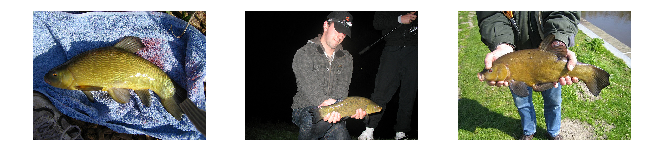

In [68]:
idxs,dists = get_knn(nn_predwv, pred)
show_imgs([open_image(PATH/md.val_ds.fnames[i]) for i in idxs[1:4]], 3, figsize=(9,3));

And here are other images of this fish. 
We trained on all of ImageNet in an hour, using a custom head that required two lines of code.
And these things run in 300 milliseconds to do these searches.

Implementing this in Keras took pages of code, a long time and complicated. 
 
TODO: **read the DeVICE paper**, it had other thoughts and 
now that it is so easy to do, hopefully people will dig into this now. 

## END